# **DATA PREPROCESSING:**

**1.Import libraries:**

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier

**2.Import dataset:**

In [6]:
df = pd.read_csv('weatherAUS.csv')
print(df.head())

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

**2.Data preprocessing: Weather dataset is preprocessed before performing classification.**

In [7]:
# Drop rows where 'RainTomorrow' is NaN
data_cleaned = df.dropna(subset=['RainTomorrow'])

# Now, separate features and target variable again
X = data_cleaned.drop('RainTomorrow', axis=1)
y = data_cleaned['RainTomorrow'].map({'Yes': 1, 'No': 0})  # Ensure this conversion has no NaN values

# Identifying numerical and categorical columns (excluding 'Date' from categorical columns)
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns.drop(['Date'])

# Preprocessor for Bayesian Networks (Ordinal Encoding for Categorical, Median Imputation for Numerical)
bn_numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

bn_categorical_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

bn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', bn_numerical_transformer, num_cols),
        ('cat', bn_categorical_transformer, cat_cols)
    ])

# Preprocessor for other classifiers (OneHot Encoding for Categorical, Median Imputation and Scaling for Numerical)
general_numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

general_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

general_preprocessor = ColumnTransformer(
    transformers=[
        ('num', general_numerical_transformer, num_cols),
        ('cat', general_categorical_transformer, cat_cols)
    ])

# Apply the preprocessing for Bayesian Networks
X_bn_preprocessed = bn_preprocessor.fit_transform(X)

# Apply the preprocessing for other classifiers
X_general_preprocessed = general_preprocessor.fit_transform(X)

# Split the preprocessed data into training and testing sets for general classifiers
X_train, X_test, y_train, y_test = train_test_split(X_general_preprocessed, y, test_size=0.2, random_state=0)

print("Bayesian Network Preprocessed Shape:", X_bn_preprocessed.shape)
print("General Classifier Preprocessed Shape:", X_train.shape, X_test.shape)

Bayesian Network Preprocessed Shape: (142193, 21)
General Classifier Preprocessed Shape: (113754, 115) (28439, 115)


**3.Evaluate Model:** This function, assesses the performance of a machine learning model using various metrics on a test dataset.
It takes as input the trained model, X_test (features), and y_test (labels).
Using sklearn metrics functions, it calculates accuracy, precision, recall, and F1-score for the model's predictions on the test set.
The calculated metrics are returned as a dictionary, providing a comprehensive overview of the model's performance.

In [8]:
def evaluate_model(model, X_test, y_test):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # Making predictions on the test set
    y_pred = model.predict(X_test)

    # Calculating metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0)
    }

    return metrics

# **LINEAR MODELS:**

**1.Logistic Regression:**

In [9]:
# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred_log_reg = log_reg.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     22067
           1       0.74      0.51      0.61      6372

    accuracy                           0.85     28439
   macro avg       0.80      0.73      0.76     28439
weighted avg       0.84      0.85      0.84     28439



**2.Logistic regression model**:  This code performs hyperparameter tuning for a Logistic Regression model using GridSearchCV, searching over a specified parameter grid.
It initializes a GridSearchCV object with the logistic regression model, parameter grid, cross-validation strategy, and scoring metric.
Then, it fits the GridSearchCV object to the training data to find the best combination of hyperparameters, printing out the best parameters and corresponding score.

In [10]:
# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Initialize the GridSearchCV object
grid_search_lr = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit it to the training data
grid_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best score for Logistic Regression:", grid_search_lr.best_score_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Best score for Logistic Regression: 0.847460315764408


**3.Baseline matrix:** This snippet establishes a baseline logistic regression model by fitting it to the training data and then evaluates its performance on the test data using the previously defined evaluate_model function. Finally, it prints out the computed metrics for the baseline logistic regression model.

In [11]:
baseline_log_reg = LogisticRegression(max_iter=1000)
baseline_log_reg.fit(X_train, y_train)
baseline_metrics = evaluate_model(baseline_log_reg, X_test, y_test)

print("Baseline Logistic Regression metrics:", baseline_metrics)

Baseline Logistic Regression metrics: {'accuracy': 0.8497134217096242, 'precision': 0.7354129263913824, 'recall': 0.5142812303829253, 'f1': 0.6052826006649428}


**4.Tuned metrics:**  This code snippet assigns the best-performing logistic regression model found through grid search to tuned_log_reg. Then, it evaluates this tuned model on the test data using the evaluate_model function and prints out the resulting metrics, providing an assessment of the tuned logistic regression model's performance.

In [12]:
# Best model from Grid Search
tuned_log_reg = grid_search_lr.best_estimator_

# Evaluate the tuned model
tuned_metrics = evaluate_model(tuned_log_reg, X_test, y_test)

print("Tuned Logistic Regression metrics:", tuned_metrics)

Tuned Logistic Regression metrics: {'accuracy': 0.8497134217096242, 'precision': 0.7354129263913824, 'recall': 0.5142812303829253, 'f1': 0.6052826006649428}


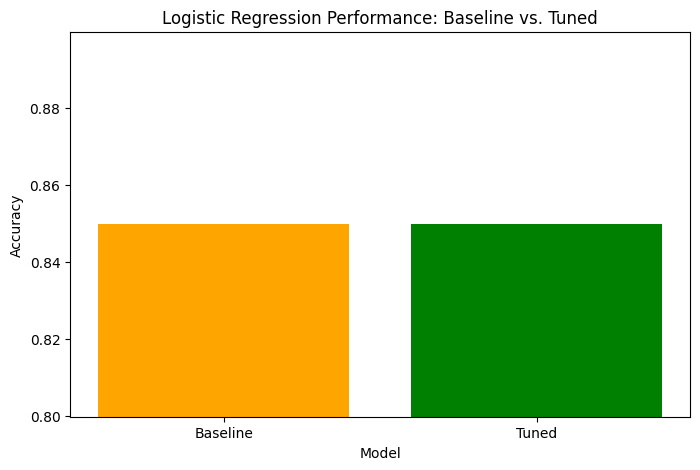

In [13]:
# Data for plotting
models = ['Baseline', 'Tuned']
accuracies = [baseline_metrics['accuracy'], tuned_metrics['accuracy']]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['Orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Performance: Baseline vs. Tuned')
plt.ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])
plt.show()

# **NAIVE BAYES:**

In [14]:
# Initialize and train the Naïve Bayes model
nb = GaussianNB()
nb.fit(X_train.toarray(), y_train)  # Convert to array if using sparse matrix

# Predictions
y_pred_nb = nb.predict(X_test.toarray())

# Evaluation
print("Naïve Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))

Naïve Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.64      0.75     22067
           1       0.37      0.72      0.49      6372

    accuracy                           0.66     28439
   macro avg       0.63      0.68      0.62     28439
weighted avg       0.77      0.66      0.69     28439



This code snippet evaluates both a baseline and a tuned Naive Bayes model. It first fits the baseline model to the training data and evaluates its performance using the evaluate_model function. Then, it performs hyperparameter tuning for Naive Bayes using GridSearchCV, searching over a specified parameter grid. It prints out the best parameters found through grid search and the corresponding best score. After tuning, it evaluates the tuned Naive Bayes model and prints its metrics. Finally, it visualizes and compares the accuracy of both baseline and tuned Naive Bayes models using a bar plot.

Baseline Naive Bayes metrics: {'accuracy': 0.6601849572769788, 'precision': 0.368509346540981, 'recall': 0.7239485247959824, 'f1': 0.4884065643197459}
Best parameters for Naive Bayes: {'var_smoothing': 1.0}
Best score for Naive Bayes: 0.8244984817476928
Tuned Naive Bayes metrics: {'accuracy': 0.8280881887548789, 'precision': 0.6802820325796256, 'recall': 0.43910860012554925, 'f1': 0.5337148307105388}


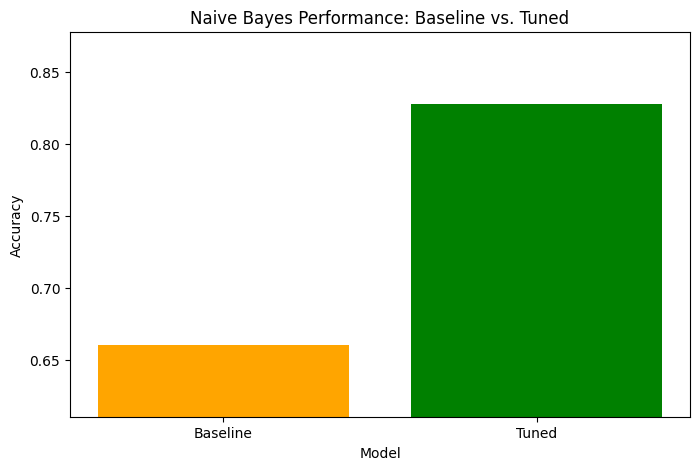

In [15]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0)
    }
    return metrics

# Baseline Naive Bayes model evaluation
baseline_nb = GaussianNB()
baseline_nb.fit(X_train.toarray(), y_train)  # Ensure X_train is converted to dense
baseline_metrics_nb = evaluate_model(baseline_nb, X_test.toarray(), y_test)  # Ensure X_test is converted to dense

print("Baseline Naive Bayes metrics:", baseline_metrics_nb)

# Hyperparameter tuning for Naive Bayes
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
grid_search_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_nb.fit(X_train.toarray(), y_train)  # Convert X_train to dense

print("Best parameters for Naive Bayes:", grid_search_nb.best_params_)
print("Best score for Naive Bayes:", grid_search_nb.best_score_)

# Evaluate the tuned Naive Bayes model
tuned_nb = grid_search_nb.best_estimator_
tuned_metrics_nb = evaluate_model(tuned_nb, X_test.toarray(), y_test)  # Convert X_test to dense

print("Tuned Naive Bayes metrics:", tuned_metrics_nb)

# Visualization
models_nb = ['Baseline', 'Tuned']
accuracies_nb = [baseline_metrics_nb['accuracy'], tuned_metrics_nb['accuracy']]

plt.figure(figsize=(8, 5))
plt.bar(models_nb, accuracies_nb, color=['orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Performance: Baseline vs. Tuned')
plt.ylim([min(accuracies_nb) - 0.05, max(accuracies_nb) + 0.05])
plt.show()


# **NON LINEAR MODELS:**

1.Decision Tree:

In [16]:
# Initialize and train the decision tree model
det = DecisionTreeClassifier(random_state=0)
det.fit(X_train, y_train)

# Predictions
y_pred_dt = det.predict(X_test)

# Evaluation
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87     22067
           1       0.54      0.55      0.55      6372

    accuracy                           0.79     28439
   macro avg       0.70      0.71      0.71     28439
weighted avg       0.80      0.79      0.80     28439



In [17]:
# Evaluate the baseline model
baseline_dt = DecisionTreeClassifier(random_state=0)
baseline_dt.fit(X_train, y_train)  # No need to convert to dense array for decision trees
baseline_metrics_dt = evaluate_model(baseline_dt, X_test, y_test)

print("Baseline Decision Tree metrics:", baseline_metrics_dt)

Baseline Decision Tree metrics: {'accuracy': 0.7942614015963994, 'precision': 0.5399846508058327, 'recall': 0.5521029504080351, 'f1': 0.5459765655311554}


In [18]:
# Hyperparameter tuning
param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10]
}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best score for Decision Tree:", grid_search_dt.best_score_)
# Evaluate the tuned model
tuned_dt = grid_search_dt.best_estimator_
tuned_metrics_dt = evaluate_model(tuned_dt, X_test, y_test)

print("Tuned Decision Tree metrics:", tuned_metrics_dt)

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 2}
Best score for Decision Tree: 0.8374475134289472
Tuned Decision Tree metrics: {'accuracy': 0.8412391434297971, 'precision': 0.7141868512110726, 'recall': 0.4858757062146893, 'f1': 0.5783132530120482}


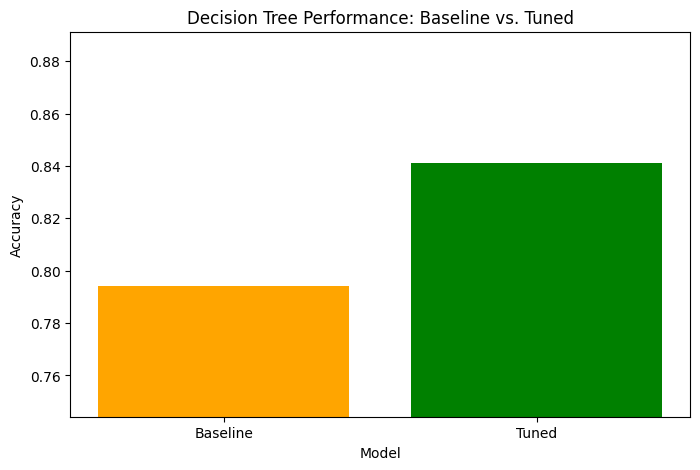

In [19]:
# Visualization
models_dt = ['Baseline', 'Tuned']
accuracies_dt = [baseline_metrics_dt['accuracy'], tuned_metrics_dt['accuracy']]

plt.figure(figsize=(8, 5))
plt.bar(models_dt, accuracies_dt, color=['orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Decision Tree Performance: Baseline vs. Tuned')
plt.ylim([min(accuracies_dt) - 0.05, max(accuracies_dt) + 0.05])
plt.show()


2.Neural Network:

In [20]:
# Initialize and train the neural network model
mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(X_train, y_train)

# Predictions
y_pred_mlp = mlp.predict(X_test)

# Evaluation
print("Neural Network Classification Report:\n", classification_report(y_test, y_pred_mlp))

Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91     22067
           1       0.69      0.59      0.64      6372

    accuracy                           0.85     28439
   macro avg       0.79      0.76      0.77     28439
weighted avg       0.84      0.85      0.85     28439



In [21]:
# Evaluate the baseline model
baseline_nn = MLPClassifier(random_state=1, max_iter=300)
baseline_nn.fit(X_train, y_train)
baseline_metrics_nn = evaluate_model(baseline_nn, X_test, y_test)

print("Baseline Neural Network metrics:", baseline_metrics_nn)

Baseline Neural Network metrics: {'accuracy': 0.8502760293962516, 'precision': 0.6941587068332109, 'recall': 0.5930634023854363, 'f1': 0.6396411645226812}


In [22]:
# Initialize and train the neural network model
mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(X_train, y_train)

# Predictions
y_pred_mlp = mlp.predict(X_test)

# Evaluation
print("Neural Network Classification Report:\n", classification_report(y_test, y_pred_mlp))

Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91     22067
           1       0.69      0.59      0.64      6372

    accuracy                           0.85     28439
   macro avg       0.79      0.76      0.77     28439
weighted avg       0.84      0.85      0.85     28439



In [23]:

# Simplified hyperparameter grid
param_dist_nn = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01],
}

# Randomized search
random_search_nn = RandomizedSearchCV(MLPClassifier(random_state=1, max_iter=100), param_distributions=param_dist_nn, n_iter=5, cv=3, scoring='accuracy', n_jobs=-1, random_state=1)
random_search_nn.fit(X_train, y_train)

print("Best parameters for Neural Network:", random_search_nn.best_params_)
print("Best score for Neural Network:", random_search_nn.best_score_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for Neural Network: {'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'activation': 'tanh'}
Best score for Neural Network: 0.8511173233468714


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [24]:
# Get the best estimator from the randomized search
tuned_nn = random_search_nn.best_estimator_

# Evaluate the tuned model
tuned_metrics_nn = evaluate_model(tuned_nn, X_test, y_test)
print("Tuned Neural Network Accuracy:", tuned_metrics_nn['accuracy'])

Tuned Neural Network Accuracy: 0.8615633461092163


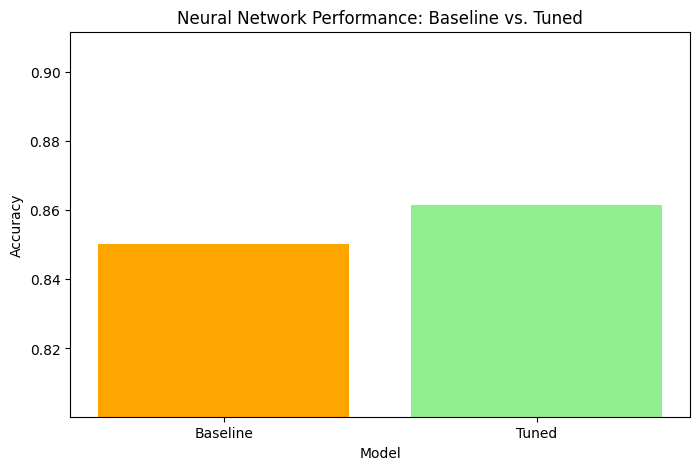

In [26]:
# Visualization
models_nn = ['Baseline', 'Tuned']
accuracies_nn = [baseline_metrics_nn['accuracy'], tuned_metrics_nn['accuracy']]

plt.figure(figsize=(8, 5))
plt.bar(models_nn, accuracies_nn, color=['orange', 'lightgreen'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Neural Network Performance: Baseline vs. Tuned')
plt.ylim([min(accuracies_nn) - 0.05, max(accuracies_nn) + 0.05])
plt.show()

# **BAYESIAN NETWORK:**

In [27]:
!pip install pgmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [28]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

# Define a simple Bayesian Network structure using the updated class name
model = BayesianNetwork([('Rainfall', 'RainTomorrow'), ('Humidity3pm', 'RainTomorrow')])

# Proceed with parameter estimation as before
data_cleaned = df.dropna(subset=['Rainfall', 'Humidity3pm', 'RainTomorrow'])
data_cleaned = data_cleaned[['Rainfall', 'Humidity3pm', 'RainTomorrow']].sample(n=5000, random_state=1)

# Fit the model
model.fit(data_cleaned, estimator=BayesianEstimator, prior_type="BDeu")

# Inference
infer = VariableElimination(model)
q = infer.query(variables=['RainTomorrow'], evidence={'Rainfall': 1, 'Humidity3pm': 50})
print(q)


+-------------------+---------------------+
| RainTomorrow      |   phi(RainTomorrow) |
+===================+=====================+
| RainTomorrow(No)  |              0.9999 |
+-------------------+---------------------+
| RainTomorrow(Yes) |              0.0001 |
+-------------------+---------------------+
